In [879]:
import numpy as np
import pandahouse as ph
from scipy.stats import chi2_contingency, chi2
import pandas as pd
import seaborn as sns
from scipy.stats import norm, mannwhitneyu, shapiro
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use('ggplot')

## Задание 1.

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [880]:
#%load_ext pycodestyle_magic

In [881]:
#%pycodestyle_off

In [882]:
df1_path = 'Проект_2_groups.csv'
df2_path = 'Проект_2_group_add.csv'
df3_path = 'Проект_2_active_studs.csv'
df4_path = 'Проект_2_checks.csv'

<b>groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

<b>groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных</b>

<b>active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.</b> 

<b>checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.</b> 

### 1.Загрузка и исследование датафреймов.

In [883]:
df_groups = pd.read_csv(df1_path, sep=';')

In [884]:
df_groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [885]:
df_groups.isna().sum()

id     0
grp    0
dtype: int64

In [886]:
df_groups.shape

(74484, 2)

In [887]:
df_add_groups = pd.read_csv(df2_path)

In [888]:
df_add_groups.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [889]:
df_add_groups.shape

(92, 2)

In [890]:
df_active = pd.read_csv(df3_path)

In [891]:
df_active.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [892]:
df_checks = pd.read_csv(df4_path, sep=';')

In [893]:
df_checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### Объединие датафреймов: исходные данные с поступившими через 2 дня.

In [894]:
df_users = pd.concat([df_groups, df_add_groups], ignore_index=True, sort=False)

In [895]:
df_users.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


#### Объединение датафреймов: пользователи, заходившие в дни эксперимента, получают колонку, обозначающую принадлежность к контрольной или тестовой группе. 

In [896]:
df_users.rename(columns={'id':'student_id'}, inplace=True)

In [897]:
df_active_users = df_active.merge(df_users, how='left', on='student_id')

In [898]:
df_active_users.head(3)

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B


#### Объединение датафреймов: объединяем с файлом, содержащим информацию об оплате пользователей. 
Для пользователей, отсутствующих в этом файле, заполняем NaN нулями, поскольку это указывает на отсутствие оплаты. 

In [899]:
df_active_users = df_active_users.merge(df_checks, how='left', on='student_id')

In [900]:
df_active_users.rev.isna().sum()

7949

In [901]:
df_active_users.rev = df_active_users.rev.fillna(0)

In [902]:
df_active_users.head(3)

,student_id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0


### 2. Оцениваем полученные данные:

#### Соотношние численности контрольной (A) и тестовой (B) групп: 

<AxesSubplot:>

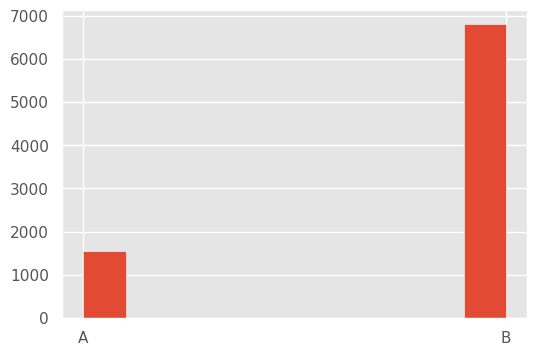

In [903]:
plt.rcParams["figure.figsize"] = [6, 4]
df_active_users.grp.hist()

In [904]:
test_number = df_active_users.query('grp == "B"').shape[0]
control_number = df_active_users.query('grp == "A"').shape[0]
print(f'Тестовая группа содержит {test_number} пользователей.')
print(f'Контрольная группа содержит {control_number} пользователей.')

#### Поскольку целью эксперимента является повышение финансовых показателей (выручка, прибыль), то для оценки результатов  проводится сравнение следующих метрик: средний доход с одного активного пользователя (ARPU), средняя выручка на одного платящего пользователя (ARPPU), конверсия пользователей. 

In [905]:
df_active_users.shape[0] == df_active_users.student_id.nunique()

True

#### Количество уникальных id студентов соответствует длине колонки id_student,  значит ARPU соответствует среднему значению колонки rev, сгруппированному по выборке.

#### Оценка ARPU в группах.

In [906]:
ARPU = df_active_users.groupby('grp', as_index=False).agg({'rev':'mean'}).rename(columns={'rev':'ARPU'})
ARPU

,grp,ARPU
0,A,47.347204
1,B,58.058798


<AxesSubplot:xlabel='grp', ylabel='ARPU'>

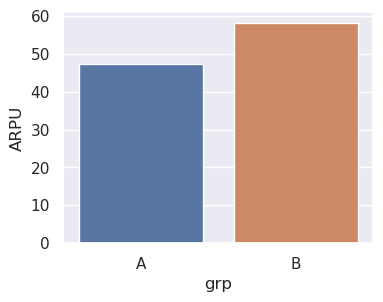

In [907]:
sns.set(rc={'figure.figsize':(4, 3)})
sns.barplot(data=ARPU, x="grp", y="ARPU")

#### В тестовой группе значение ARPU выше.

#### Оценка распределения оплаты среди пользователей контрольной группы.

In [908]:
df_arpu_a = df_active_users.query('grp == "A"')
df_arpu_b = df_active_users.query('grp == "B"')

<AxesSubplot:>

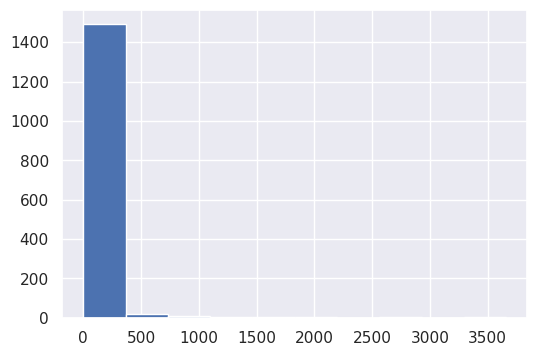

In [909]:
plt.rcParams["figure.figsize"] = [6, 4]
df_arpu_a.rev.hist()

In [910]:
shapiro(df_arpu_a.rev)

ShapiroResult(statistic=0.1541670560836792, pvalue=0.0)

#### Оценка распределения оплаты среди пользователей целевой группы.

<AxesSubplot:>

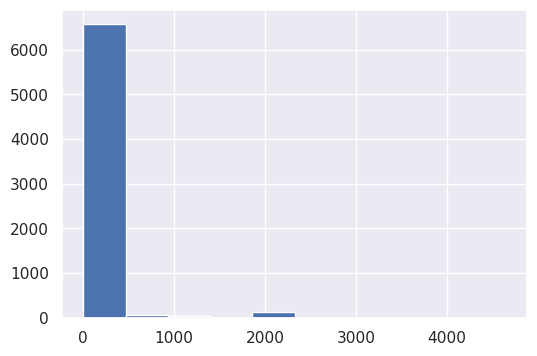

In [911]:
plt.rcParams["figure.figsize"] = [6, 4]
df_arpu_b.rev.hist()

In [912]:
shapiro(df_arpu_b.rev)

/home/m/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.18124502897262573, pvalue=0.0)

#### В обеих выборках распределение не является нормальным (p-уровень значимости теста Шапиро-Уилка меньше 0.05). Соответственно, для оценки статистической достоверности результатов необходимо использовать либо непараметрические методы, либо bootstrap. В связи с трудностью интерпритации теста Манна-Уитни (он оценивает не равенство средних, а равенстово распределений), в данном случае будет применяться bootstrap, исходя из предположения о репрезентативнгсти выборок.

#### Объявление функции для оценки статистической достоверности на основе bootstrap.

In [913]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len,
                                         replace=True  # параметр возвращения
                                         ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

#### Оценка статистической достоверности отличий между контрольной и тестовыми группами. 

  0%|          | 0/1000 [00:00<?, ?it/s]

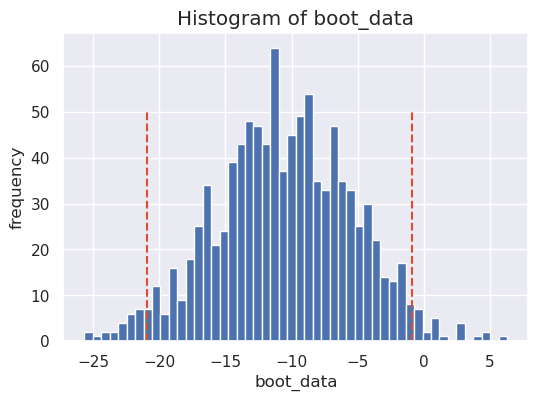

In [914]:
result_arpu = get_bootstrap(df_arpu_a.rev, df_arpu_b.rev)

In [915]:
result_arpu['p_value']

0.04125126016030747

#### На основе полученных данных можно отклонить нулевую гипотезу об отсутствии статистически достоверных различий в контрольной и тестовой группах (p < 0.05) 

#### ARPPU - средняя выручка на одного платящего пользователя. 

In [916]:
ARPPU = df_active_users.query('rev > 0'). \
        groupby('grp', as_index=False). \
        agg({'rev' : 'mean'}). \
        rename(columns = {'rev' : 'ARPPU'})
ARPPU

,grp,ARPPU
0,A,933.589744
1,B,1257.878992


<AxesSubplot:xlabel='grp', ylabel='ARPPU'>

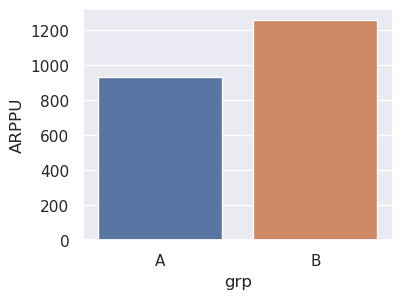

In [917]:
sns.set(rc={'figure.figsize':(4, 3)})
sns.barplot(data=ARPPU, x="grp", y="ARPPU")

#### В тестовой группе значение ARPPU выше. 

#### Оценка распределений.

In [918]:
df_arppu_a = df_active_users.query('grp == "A" and rev > 0')
df_arppu_b = df_active_users.query('grp == "B" and rev > 0')

<AxesSubplot:>

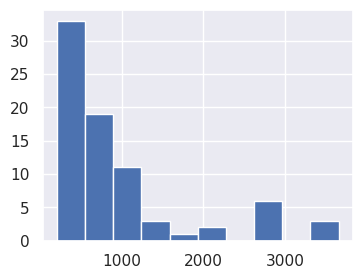

In [919]:
df_arppu_a.rev.hist()

In [920]:
shapiro(df_arppu_a.rev)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

<AxesSubplot:>

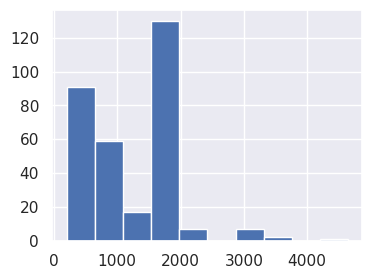

In [921]:
df_arppu_b.rev.hist()

In [922]:
shapiro(df_arppu_b.rev)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

#### Поскольку оба распределения также отличаются от нормального, то для последующей оценки статистически достоверных различий применяется bootstrap. 

  0%|          | 0/1000 [00:00<?, ?it/s]

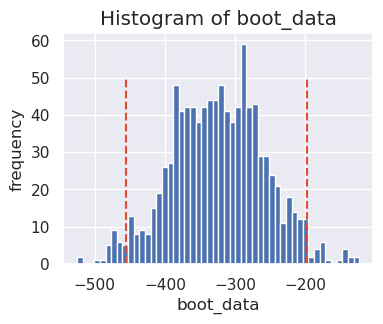

In [923]:
result_arppu = get_bootstrap(df_arppu_a.rev, df_arppu_b.rev)

In [924]:
result_arppu['p_value']

1.0983786407497397e-06

#### На основе полученных данных можно отклонить нулевую гипотезу об отсутствии статистически достоверных различий в контрольной и тестовой группах (p < 0.05) 

### Оценка уровня конверсии.

In [925]:
conversion_test = df_active_users.query('rev > 0 and grp == "B"'). \
                    student_id.nunique() / df_active_users. \
                    query('grp == "B"').student_id.nunique()
print('Конверсия в тестовой группе:')
conversion_test

0.046156107599588415

In [926]:
conversion_control = df_active_users.query('rev > 0 and grp == "A"'). \
                    student_id.nunique() / df_active_users. \
                    query('grp == "A"').student_id.nunique()
print('Конверсия в контрольной группе:')
conversion_control

0.05071521456436931

<AxesSubplot:xlabel='grp', ylabel='conversion'>

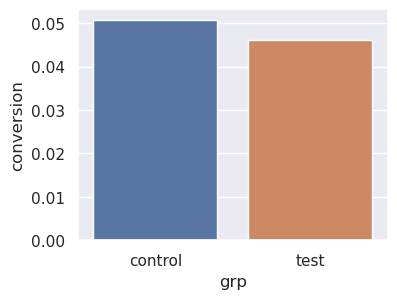

In [927]:
conversion = pd.DataFrame({'grp' : ['control', 'test'], 'conversion' : [conversion_control, conversion_test]})
sns.set(rc={'figure.figsize':(4, 3)})
sns.barplot(data = conversion, x = "grp", y = "conversion")

#### В тестовой группе значение конверсии ниже.

#### Конверсия оценивается на основе двух категориальных переменных, следовательно целессобразно применение метода на основе критерия χ2 Пирсона.

In [928]:
conversion_a = df_active_users.query('rev > 0 and grp == "A"').student_id.nunique()  
non_conversion_a = df_active_users.query('rev == 0 and grp == "A"').student_id.nunique()
conversion_b = df_active_users.query('rev > 0 and grp == "B"').student_id.nunique() 
non_conversion_b = df_active_users.query('rev == 0 and grp == "B"').student_id.nunique()

In [929]:
# chi-square
data = [[conversion_a, non_conversion_a], [conversion_b, non_conversion_b]]
stat, p, dof, expected = chi2_contingency(data)

In [930]:
p

0.48625240457231045

#### На основе полученных данных нельзя отклонить нулевую гипотезу об отсутствии статистически достоверных различий в контрольной и тестовой группах (p > 0.05) 

### На основе проведенного анализа можно сделать следующие выводы:


#### В тестовой группе отмечается статистически достоверное повышение ARPU и ARPPU.
#### Статистически достоверных различий в уровне конверсии между тестовой и контрольной группе нет. 
#### Целесообразно применить данную механику оплаты на всех пользователей.
#### Целесообразно сосредоточиться на повышении конверсии.

## Задание 2. SQL.



#### 2.1 Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин. 
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

In [931]:
connection = {'host': 'http://clickhouse.beslan.pro:8080',
'database':'default',
'user':'student',
'password':'dpo_python_2020'
}

In [932]:
query = '''SELECT COUNT (*) AS number
           FROM (SELECT st_id, SUM(correct) AS result
                 FROM peas
                 WHERE toStartOfMonth(timest) = date_trunc('month', now())
           GROUP BY st_id
           HAVING result > 19)'''

In [933]:
df = ph.read_clickhouse(query, connection=connection)

#### Поскольку по условию задания должны выводиться данные за текущий месяц, а в таблице представлена информация за октябрь 2021, результатом запроса является 0.

In [934]:
df

,number
0,0


#### 2.2 Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

    ARPU 
    ARPAU 
    CR в покупку 
    СR активного пользователя в покупку 
    CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.


In [935]:
query_2 = '''SELECT test_grp,
                    COUNT(DISTINCT(st_id)) as users_by_groups,
                    SUM(revenue) as revenue,
                    SUM(active) as active_users,
                    SUM(conversion) / users_by_groups * 100 AS all_conversion,
                    SUM(active_convers) / active_users * 100 AS active_conversion,
                    SUM(is_active_client_math) / SUM(math_active) * 100 AS math_conversion,
                    revenue/users_by_groups as ARPU,
                    revenue/active_users as ARPAU

             FROM  (WITH    

                    -- money

                     money AS (SELECT st_id, SUM(money) AS revenue
                               FROM   final_project_check
                               GROUP BY st_id
                              ),

                    -- is active user

                    is_active AS (SELECT st_id,
                                         IF(SUM(correct) > 10, 1, 0) AS active 
                                  FROM peas
                                  GROUP BY st_id
                                  ),

                    -- math active user

                    m_active AS (SELECT st_id,
                                        IF(SUM(correct) >= 2, 1, 0) AS math_active 
                                 FROM (SELECT * 
                                       FROM peas
                                       WHERE subject='Math'
                                       )
                                 GROUP BY st_id
                                ),

                    -- conversion

                    conv AS (SELECT st_id,
                                    if(SUM(money) > 0, 1, 0) AS conversion 
                             FROM final_project_check
                             GROUP BY st_id
                             ),

                    -- active conversion

                    act_conv AS (SELECT st_id,
                                        IF((SUM(money) > 0) AND st_id IN (SELECT st_id 
                                                                          FROM peas 
                                                                          GROUP BY st_id 
                                                                          HAVING (SUM(correct) > 10)
                                                                          ), 1, 0)
                                                                          AS active_convers
                                 FROM final_project_check
                                 GROUP BY st_id
                                 ),

                    -- math bought

                     m_buy AS (SELECT DISTINCT(st_id),
                                      IF(st_id IN (SELECT st_id 
                                                   FROM final_project_check 
                                                   WHERE subject='Math'), 1, 0) 
                                      AS math_buy 
                               FROM final_project_check
                               ),


                    -- st_id, test_grp

                    main AS (SELECT DISTINCT(st_id) AS st_id, test_grp
                             FROM
                                 (SELECT peas.correct, peas.subject, studs.test_grp AS test_grp, studs.st_id AS st_id
                                  FROM peas 
                                  FULL JOIN studs 
                                  ON peas.st_id = studs.st_id)
                             )

                    SELECT main.st_id AS st_id, main.test_grp AS test_grp,
                           money.revenue AS revenue,
                           is_active.active AS active,
                           m_active.math_active AS math_active,
                           conv.conversion AS conversion,
                           m_buy.math_buy AS math_buy,
                           act_conv.active_convers AS active_convers,
                           CASE
                           WHEN ((math_buy = 1) AND (math_active = 1)) THEN 1
                           ELSE 0
                           END AS is_active_client_math
                    FROM main 
                         FULL JOIN money
                         ON main.st_id = money.st_id
                         FULL JOIN is_active
                         ON main.st_id = is_active.st_id
                         FULL JOIN m_active
                         ON main.st_id = m_active.st_id
                         FULl JOIN conv
                         ON main.st_id = conv.st_id
                         FULL JOIN m_buy
                         ON main.st_id = m_buy.st_id
                         FULL JOIN act_conv
                         ON main.st_id = act_conv.st_id)

                    GROUP BY test_grp'''

In [936]:
df_2 = ph.read_clickhouse(query_2, connection = connection)

In [937]:
df_2

,test_grp,users_by_groups,revenue,active_users,all_conversion,active_conversion,math_conversion,ARPU,ARPAU
0,control,305,1385000,127,4.918033,11.023622,6.122449,4540.983607,10905.511811
1,pilot,295,3395000,96,10.847458,26.041667,9.523810,11508.474576,35364.583333


Показатели рассчитывались следующим образом:

ARPU - суммарная выручка / общее количество пользователей.

ARPAU - суммарная выручка / количество активных пользователей.

CR в покупку - (количество пользователей, совершивших покупку / общее количество пользователей) * 100%

СR активного пользователя в покупку - (количество активных пользователей, совершивших покупку / количество активных пользователей) * 100%

CR пользователя из активности по математике в покупку курса по математике - количество активных по математике пользователей, купивших курс / количество активных по математике пользователей


### Задание 3. Python

#### 3.1 Задача

    Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
    Реализуйте функцию, которая будет строить графики по получаемым метрикам.

#### Функция data_update принимает 1 параметр: сслыку на файл с дополнительными данными. 

In [938]:
def data_update(add_file):
    df1_path = 'Проект_2_groups.csv'
    df3_path = 'Проект_2_active_studs.csv'
    df4_path = 'Проект_2_checks.csv'
    column_names = ['id', 'grp']
    df_add_groups = pd.read_csv(add_file, names=column_names, header=None)
    df_groups = pd.read_csv(df1_path, sep = ';')
    df_users = pd.concat([df_groups, df_add_groups], ignore_index=True, sort=False)
    df_active = pd.read_csv(df3_path)
    df_checks = pd.read_csv(df4_path, sep = ';')
    df_users.rename(columns={'id' : 'student_id'}, inplace=True)
    df_active_users = df_active.merge(df_users, how = 'left', on = 'student_id')
    df_active_users = df_active_users.merge(df_checks, how = 'left', on = 'student_id')
    df_active_users.rev =  df_active_users.rev.fillna(0)
    df_active_users['grp'] = df_active_users['grp'].apply(lambda x: 'control' if x == 'A' else 'test')
    ARPU = df_active_users.groupby('grp', as_index=False).agg({'rev' : 'mean'}).rename(columns = {'rev' : 'ARPU'})
    ARPPU = df_active_users.query('rev > 0').groupby('grp', as_index=False).agg({'rev' : 'mean'}).rename(columns = {'rev' : 'ARPPU'})
    conversion_test = df_active_users.query('rev > 0 and grp == "test"').student_id.nunique() / df_active_users.query('grp == "test"') \
    .student_id.nunique()
    conversion_control = df_active_users.query('rev > 0 and grp == "control"').student_id.nunique() / df_active_users.query('grp == "control"') \
    .student_id.nunique()
    conversion = pd.DataFrame({'grp' : ['control', 'test'], 'conversion' : [conversion_control, conversion_test]})
    return ARPU, ARPPU, conversion

In [939]:
ARPU, ARPPU, conversion = data_update('Проект_2_group_add.csv')

#### Функция draw принимает 3 параметра: ARPU, ARPPU, конверсию. 

In [940]:
def draw(ARPU, ARPPU, conversion):
    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(16, 4))
    sns.barplot(ax=axes[0], data=ARPU, x="grp", y="ARPU")
    sns.barplot(ax=axes[1], data=ARPPU, x="grp", y="ARPPU")
    sns.barplot(ax=axes[2], data = conversion, x = "grp", y = "conversion")

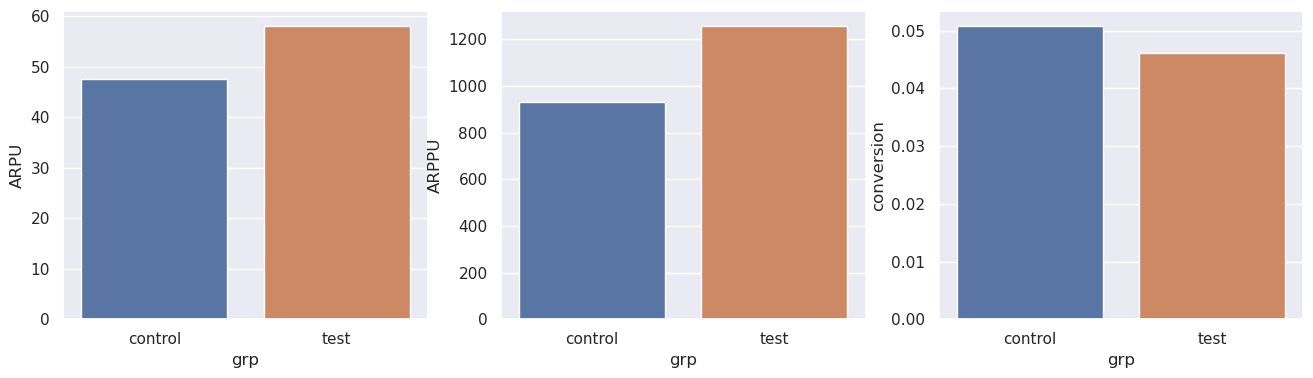

In [941]:
draw(ARPU, ARPPU, conversion)